### LOAD DATASET

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob 
import time
from sklearn.cross_validation import KFold, train_test_split
from sklearn.utils import shuffle
from keras.utils import np_utils

train = pd.read_csv('training_images_size.csv', sep='\t')
test = pd.read_csv('testing_images_size.csv', sep='\t')

### DATA PREPROCESSING 

In [75]:
def read_img(path, h=250, w=250):
    'read, resize, and convert an image to grayscale'
    img = cv2.imread(path)
    resize = cv2.resize(img, (h, w), cv2.INTER_LINEAR)
    #gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    return resize

In [76]:
train_paths = train.imagepath.values
test_paths = glob('test/*')

In [169]:
def load_train(train_path):
    train_data = []
    train_target = []
    train_id = []
    start_time = time.time()
    for path in train_paths:
        train_id.append(path)
        train_data.append(read_img(path))
        target = path.split('/')[1]
        target = target.split('_')[1]
        train_target.append(target)
    print ('Training data load time: {}'.format(time.time() - start_time))
    return train_data, train_target, train_id

def load_test(test_paths):
    test_data = []
    test_id = []
    start_time = time.time()
    for path in test_paths:
        test_id.append(path)
        test_data.append(read_img(path))
    print ('Testing data load time: {}'.format(time.time() - start_time))
    return test_data, test_id

In [170]:
train_data, train_target, train_id = load_train(train_paths)
test_data, test_id = load_test(test_paths)

Training data load time: 283.82017159461975
Testing data load time: 100.45294618606567


In [183]:
train_target = [int(x) for x in train_target]


### IMAGE AUGMENTATION AND NORMALIZATION

In [79]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [84]:
traindata1 = train_data[0].reshape((1,)+train_data[0].shape)
i = 0 
for bath in datagen.flow(traindata1, 
                         batch_size=1,
                         save_to_dir='preview',
                         save_prefix='type_1',
                         save_format='jpeg'):
    i += 1
    if i > 20:
        break

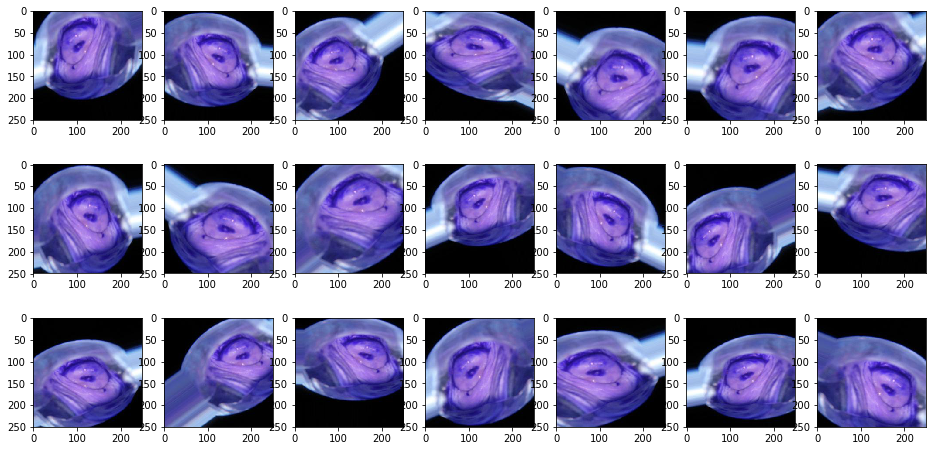

In [90]:
preview_path = glob('preview/*')
fig = plt.figure(figsize=(16,8))
for i, path in enumerate(preview_path):
    ax = fig.add_subplot(3, 7, i+1)
    plt.imshow(plt.imread(path))

In [188]:
def normalize_data(data):
    data = np.array(data, dtype=np.uint8)
    data = data.astype('float32')
    data = data/255
    return data

train_data = normalize_data(train_data)
print ('Shape of the training data is ', train_data.shape)

Shape of the training data is  (1481, 250, 250, 3)


In [189]:
test_data = normalize_data(test_data)
print ('Shape of the training data is ', test_data.shape)

Shape of the training data is  (503, 250, 250, 3)


### BUILDING MODEL

In [195]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

#Build the first model with a simple stack of 3 convolution layers with a ReLU activation and following by
# max-pooling layers

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(250, 250, 3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#Add flatten
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
             optimizer=sgd)

model.fit(train_data, train_target, 
         batch_size=32, epochs=10)

ValueError: You are passing a target array of shape (1481, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.